# Mixed Distance Functions for  k-Nearest Neighbor


This function shows how to use different distance metrics on different features for kNN.

#### Data:
----------x-values-----------
* CRIM   : per capita crime rate by town
* ZN     : prop. of res. land zones
* INDUS  : prop. of non-retail business acres
* CHAS   : Charles river dummy variable
* NOX    : nitrix oxides concentration / 10 M
* RM     : Avg. # of rooms per building
* AGE    : prop. of buildings built prior to 1940
* DIS    : Weighted distances to employment centers
* RAD    : Index of radian highway access
* TAX    : Full tax rate value per $10k
* PTRATIO: Pupil/Teacher ratio by town
* B      : 1000*(Bk-0.63)^2, Bk=prop. of blacks
* LSTAT  : % lower status of pop

------------y-value-----------
* MEDV   : Median Value of homes in $1,000's

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops
ops.reset_default_graph()

### Create graph

In [2]:
sess = tf.Session()

### Load the data

In [3]:
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)
housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

## Min-Max Scaling
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

## Create distance metric weight matrix weighted by standard deviation
weight_diagonal = x_vals.std(0)
weight_matrix = tf.cast(tf.diag(weight_diagonal), dtype=tf.float32)

# Split the data into train and test sets
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

### Declare k-value and batch size

In [4]:
k = 4
batch_size=len(x_vals_test)

# Placeholders
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [6]:
# Declare weighted distance metric
# Weighted - L2 = sqrt((x-y)^T * A * (x-y))
subtraction_term =  tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))
first_product = tf.matmul(subtraction_term, tf.tile(tf.expand_dims(weight_matrix,0), [batch_size,1,1]))
second_product = tf.matmul(first_product, tf.transpose(subtraction_term, perm=[0,2,1]))
distance = tf.sqrt(tf.matrix_diag_part(second_product))

### Predict: Get min distance index (Nearest neighbor)

In [7]:
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)
x_sums_repeated = tf.matmul(x_sums,tf.ones([1, k], tf.float32))
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated), 1)

top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals), axis=[1])

# Calculate MSE
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)

# Calculate how many loops over training data
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

for i in range(num_loops):
    min_index = i*batch_size
    max_index = min((i+1)*batch_size,len(x_vals_train))
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})

    print('Batch #' + str(i+1) + ' MSE: ' + str(np.round(batch_mse,3)))

Batch #1 MSE: 17.735


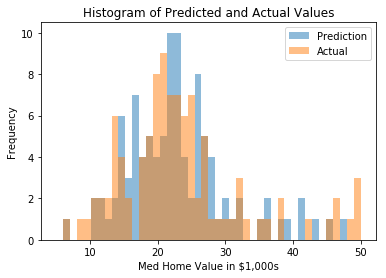

In [8]:
%matplotlib inline
# Plot prediction and actual distribution
bins = np.linspace(5, 50, 45)

plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()